In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [ ]:
# Load the datasets
df1 = pd.read_csv('chemdata20.csv')
df2 = pd.read_csv('chemdata16.csv')
df3 = pd.read_csv('chemdata12.csv')

# Concatenate the datasets
df = pd.concat([df1, df2, df3], ignore_index=True)

In [ ]:
df.shape

(200, 14)

In [ ]:
df.head()

,Initial Conc. of MB (mg/L),Catalyst dose (mg/L),light intensity(A),Time (min),Final Conc. of MB (mg/L),Removal (%),Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,5.0,100.0,20.0,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,100.0,20.0,15.0,1.3,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,100.0,20.0,30.0,0.8,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.0,100.0,20.0,45.0,0.6,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,100.0,20.0,60.0,0.4,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.tail()

,Initial Conc. of MB (mg/L),Catalyst dose (mg/L),light intensity(A),Time (min),Final Conc. of MB (mg/L),Removal (%),Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
195,15.0,400.0,12.0,30.0,6.9,54.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196,15.0,400.0,12.0,45.0,5.8,61.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,15.0,400.0,12.0,60.0,5.0,66.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,15.0,400.0,12.0,75.0,4.1,72.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,15.0,400.0,4.0,90.0,3.4,77.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.columns.unique()

Index(['Initial Conc. of MB (mg/L)', 'Catalyst dose (mg/L)',
       'light intensity(A)', 'Time (min)', 'Final Conc. of MB (mg/L)',
       'Removal (%)', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13'],
      dtype='object')

In [ ]:
columns_to_drop = ['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13']
df = df.drop(columns=columns_to_drop)

In [ ]:
df.shape

(200, 6)

In [ ]:
df.head(10)

,Initial Conc. of MB (mg/L),Catalyst dose (mg/L),light intensity(A),Time (min),Final Conc. of MB (mg/L),Removal (%)
0,5.0,100.0,20.0,0.0,5.0,0.0
1,5.0,100.0,20.0,15.0,1.3,74.0
2,5.0,100.0,20.0,30.0,0.8,84.0
3,5.0,100.0,20.0,45.0,0.6,88.0
4,5.0,100.0,20.0,60.0,0.4,92.0
5,5.0,100.0,20.0,75.0,0.4,92.0
6,5.0,100.0,20.0,90.0,0.3,94.0
7,5.0,250.0,20.0,0.0,5.0,0.0
8,5.0,250.0,20.0,15.0,1.2,76.0
9,5.0,250.0,20.0,30.0,0.7,86.0


**Data Preprocessing**

In [ ]:
# Rename columns
df1 = df.copy()
df1.rename(
    columns={
        'Initial Conc. of MB (mg/L)': 'ICMB',
        'Catalyst dose (mg/L)': 'CD',
        'light intensity(A)': 'LI',
        'Time (min)': 'Time',
        'Final Conc. of MB (mg/L)': 'FCMB',
        'Removal (%)': 'Rem'
    }, inplace=True
)

In [ ]:
df1.head(10)

,ICMB,CD,LI,Time,FCMB,Rem
0,5.0,100.0,20.0,0.0,5.0,0.0
1,5.0,100.0,20.0,15.0,1.3,74.0
2,5.0,100.0,20.0,30.0,0.8,84.0
3,5.0,100.0,20.0,45.0,0.6,88.0
4,5.0,100.0,20.0,60.0,0.4,92.0
5,5.0,100.0,20.0,75.0,0.4,92.0
6,5.0,100.0,20.0,90.0,0.3,94.0
7,5.0,250.0,20.0,0.0,5.0,0.0
8,5.0,250.0,20.0,15.0,1.2,76.0
9,5.0,250.0,20.0,30.0,0.7,86.0


In [ ]:
df1.isnull().sum()

ICMB    11
CD      11
LI       7
Time    11
FCMB    11
Rem      7
dtype: int64

In [ ]:
null_values = df1[df1['ICMB'].isnull()]

print(null_values)

     ICMB  CD    LI  Time  FCMB          Rem
21    NaN NaN   NaN   NaN   NaN          NaN
43    NaN NaN   NaN   NaN   NaN          NaN
86    NaN NaN  16.0   NaN   NaN      #DIV/0!
108   NaN NaN  16.0   NaN   NaN      #DIV/0!
130   NaN NaN   NaN   NaN   NaN          NaN
131   NaN NaN   NaN   NaN   NaN          NaN
132   NaN NaN   NaN   NaN   NaN          NaN
133   NaN NaN   NaN   NaN   NaN          NaN
134   NaN NaN   NaN   NaN   NaN          NaN
156   NaN NaN  12.0   NaN   NaN  Removal (%)
178   NaN NaN  12.0   NaN   NaN  Removal (%)


In [ ]:
null_positions = df1[df1['ICMB'].isnull()].index
print(null_positions)

Index([21, 43, 86, 108, 130, 131, 132, 133, 134, 156, 178], dtype='int64')


In [ ]:
null_positions = df1[df1['Rem'].isnull()].index
print(null_positions)

Index([21, 43, 130, 131, 132, 133, 134], dtype='int64')


In [ ]:
indices_to_remove = [86, 108, 156, 178]

# Remove the specified rows by index
df1 = df1.drop(index=indices_to_remove)
# If you want to reset the index after dropping the rows
#df = df.reset_index(drop=True)

In [ ]:
null_values = df1[df1['ICMB'].isnull()]

print(null_values)

     ICMB  CD  LI  Time  FCMB  Rem
21    NaN NaN NaN   NaN   NaN  NaN
43    NaN NaN NaN   NaN   NaN  NaN
130   NaN NaN NaN   NaN   NaN  NaN
131   NaN NaN NaN   NaN   NaN  NaN
132   NaN NaN NaN   NaN   NaN  NaN
133   NaN NaN NaN   NaN   NaN  NaN
134   NaN NaN NaN   NaN   NaN  NaN


In [ ]:
df1.head(25)

,ICMB,CD,LI,Time,FCMB,Rem
0,5.0,100.0,20.0,0.0,5.0,0.0
1,5.0,100.0,20.0,15.0,1.3,74.0
2,5.0,100.0,20.0,30.0,0.8,84.0
3,5.0,100.0,20.0,45.0,0.6,88.0
4,5.0,100.0,20.0,60.0,0.4,92.0
5,5.0,100.0,20.0,75.0,0.4,92.0
6,5.0,100.0,20.0,90.0,0.3,94.0
7,5.0,250.0,20.0,0.0,5.0,0.0
8,5.0,250.0,20.0,15.0,1.2,76.0
9,5.0,250.0,20.0,30.0,0.7,86.0


In [ ]:
# List of indices with NaN values that we will remove
indices_to_remove = [21, 43, 130, 131, 132, 133, 134]

# Remove the specified rows by index
df1 = df1.drop(index=indices_to_remove)


In [ ]:
df1.isnull().sum()

ICMB    0
CD      0
LI      0
Time    0
FCMB    0
Rem     0
dtype: int64

In [ ]:
df1.head(
)

,ICMB,CD,LI,Time,FCMB,Rem
0,5.0,100.0,20.0,0.0,5.0,0.0
1,5.0,100.0,20.0,15.0,1.3,74.0
2,5.0,100.0,20.0,30.0,0.8,84.0
3,5.0,100.0,20.0,45.0,0.6,88.0
4,5.0,100.0,20.0,60.0,0.4,92.0


In [ ]:
df1.describe()

,ICMB,CD,LI,Time,FCMB
count,189.000000,189.000000,189.000000,189.000000,189.000000
mean,10.000000,250.000000,15.957672,45.000000,3.631746
std,4.093326,122.799785,3.376752,30.079681,3.845922
min,5.000000,100.000000,4.000000,0.000000,0.000000
25%,5.000000,100.000000,12.000000,15.000000,0.700000
50%,10.000000,250.000000,16.000000,45.000000,2.200000
75%,15.000000,400.000000,20.000000,75.000000,5.000000
max,15.000000,400.000000,20.000000,90.000000,15.000000


In [ ]:
# Prepare the features and target
X = df1.drop(columns=['Rem'], axis=1)
y = df1['Rem']

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the search space for hyperparameters
search_spaces = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 20),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20)
}

# Initialize the models with Bayesian optimization
opt_rf = BayesSearchCV(estimator=RandomForestRegressor(), search_spaces=search_spaces, n_iter=32, cv=3, random_state=42, n_jobs=-1)
opt_gbr = BayesSearchCV(estimator=GradientBoostingRegressor(), search_spaces=search_spaces, n_iter=32, cv=3, random_state=42, n_jobs=-1)

# Fit the base models
opt_rf.fit(x_train, y_train)
opt_gbr.fit(x_train, y_train)

# Get the best models
model1 = opt_rf.best_estimator_
model2 = opt_gbr.best_estimator_

# Generate base model predictions on training and testing data
base_pred_train1 = model1.predict(x_train)[:, np.newaxis]
base_pred_train2 = model2.predict(x_train)[:, np.newaxis]
base_pred_test1 = model1.predict(x_test)[:, np.newaxis]
base_pred_test2 = model2.predict(x_test)[:, np.newaxis]

# Create stacked features for training and testing data
x_train_stacked = np.concatenate((x_train, base_pred_train1, base_pred_train2), axis=1)
x_test_stacked = np.concatenate((x_test, base_pred_test1, base_pred_test2), axis=1)

# Define and train the meta-model
meta_model = LinearRegression()
meta_model.fit(x_train_stacked, y_train)

# Make final predictions on the testing set using the stacked features
y_pred = meta_model.predict(x_test_stacked)

# Evaluate performance using mean squared error (MSE), mean absolute error (MAE), and R-squared
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 4.867621811018981
Mean Absolute Error: 1.5631925784178151
R-squared: 0.992211541360565


In [ ]:
y.describe()

count      189
unique      94
top       0.00
freq        18
Name: Rem, dtype: object

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.5 MB/s eta 0:00:00


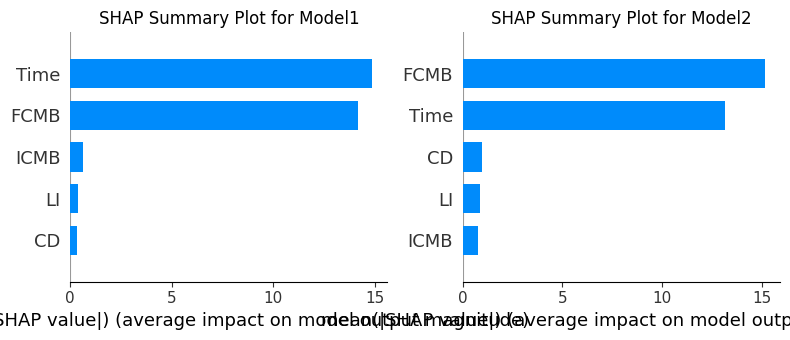

TypeError: loop of ufunc does not support argument 0 of type Explanation which has no callable conjugate method

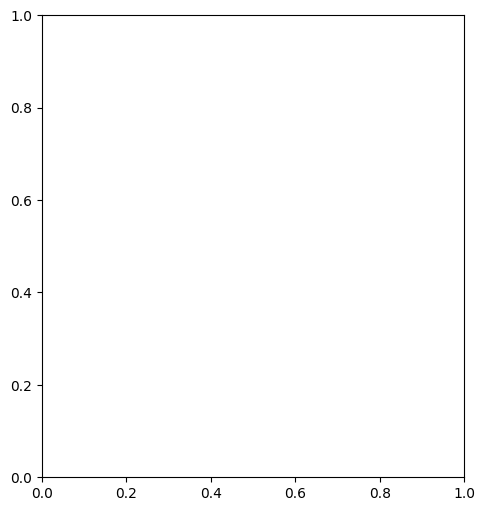

In [ ]:
# Compute SHAP values
import shap
explainer1 = shap.Explainer(model1, x_train)
explainer2 = shap.Explainer(model2, x_train)

shap_values1 = explainer1(x_train, check_additivity = False)
shap_values2 = explainer2(x_train, check_additivity = False)

# Plot SHAP summary plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
shap.summary_plot(shap_values1, features=x_train, plot_type='bar', show=False)
plt.title('SHAP Summary Plot for Model1')

plt.subplot(1, 2, 2)
shap.summary_plot(shap_values2, features=x_train, plot_type='bar', show=False)
plt.title('SHAP Summary Plot for Model2')

plt.tight_layout()
plt.show()

# Optionally, plot dependence plots for specific features
plt.figure(figsize=(12, 6))
feature_name = 'ICMB'  # Example feature name

plt.subplot(1, 2, 1)
shap.dependence_plot(feature_name, shap_values1, x_train, show=False)
plt.title(f'SHAP Dependence Plot for {feature_name} in Model1')

plt.subplot(1, 2, 2)
shap.dependence_plot(feature_name, shap_values2, x_train, show=False)
plt.title(f'SHAP Dependence Plot for {feature_name} in Model2')

plt.tight_layout()
plt.show()

*Scatterplot*

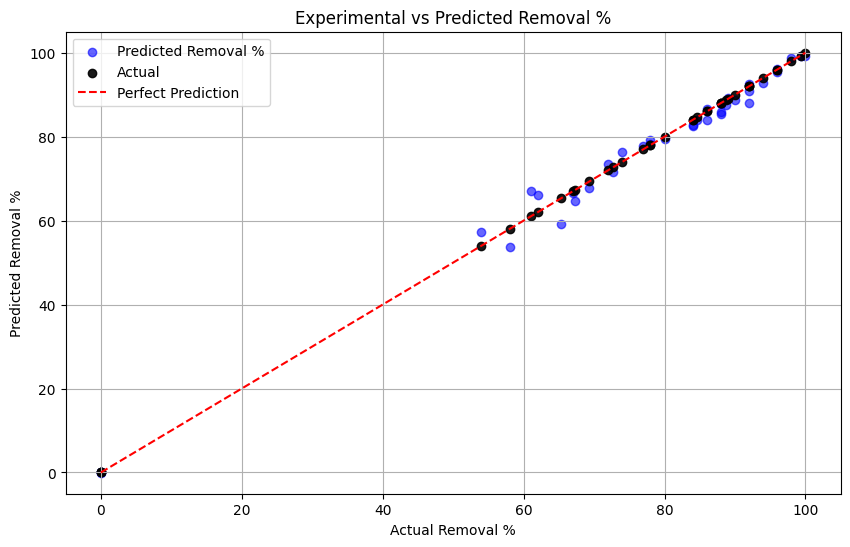

In [ ]:
# Scatter plot of Experimental vs Predicted Removal % with regression line
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Convert y_test and y_pred to numerical type if they are not already
y_test_num = y_test.astype(float)  # Convert to float if necessary
y_pred_num = y_pred.astype(float)  # Convert to float if necessary

plt.scatter(y_test_num, y_pred_num, alpha=0.6, color='b', label='Predicted Removal %')
plt.scatter(y_test_num, y_test_num, alpha=0.9, color='black', label='Actual')
plt.plot([min(y_test_num), max(y_test_num)], [min(y_test_num), max(y_test_num)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Removal %')
plt.ylabel('Predicted Removal %')
plt.title('Experimental vs Predicted Removal %')
plt.legend()
plt.grid(True)
plt.show()

*Residual Plot*

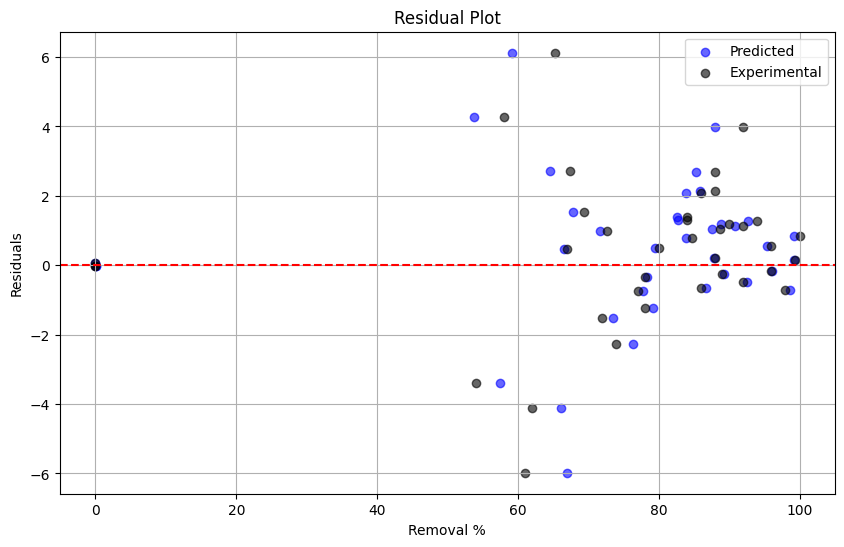

In [ ]:
# Residual plot with predicted and experimental Removal (%)
residuals = y_test.astype(float) - y_pred  # Convert y_test to float before subtraction
plt.figure(figsize=(10, 6))

# Blue dots for predicted Removal (%)
plt.scatter(y_pred, residuals, alpha=0.6, color='b', label='Predicted')

# Black dots for experimental Removal (%)
plt.scatter(y_test.astype(float), residuals, alpha=0.6, color='k', label='Experimental') # Also convert here for consistency

# Horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel('Removal %')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

Now we have to perform the same analysis with performance metrices for other algorithms:
- HistGradientBoosting
- Bagging
- Adaboost
- Randomforest
- GradientBoosting
- ExtraTree
-Decision Tree
- XGBoost
-Catboost
-LightBoost



In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 3.3 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [ ]:
df2 = df1.copy()

In [ ]:
df2.head()

,ICMB,CD,LI,Time,FCMB,Rem
0,5.0,100.0,20.0,0.0,5.0,0.0
1,5.0,100.0,20.0,15.0,1.3,74.0
2,5.0,100.0,20.0,30.0,0.8,84.0
3,5.0,100.0,20.0,45.0,0.6,88.0
4,5.0,100.0,20.0,60.0,0.4,92.0


In [ ]:
# Prepare the features and target
X = df2.drop(columns=['Rem'], axis=1)
y = df2['Rem']

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the search space for hyperparameters
search_spaces = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 20),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20)
}


In [ ]:
# Initialize the models with Bayesian optimization
models = {
    'RandomForest': BayesSearchCV(estimator=RandomForestRegressor(), search_spaces=search_spaces, n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'GradientBoosting': BayesSearchCV(estimator=GradientBoostingRegressor(), search_spaces=search_spaces, n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'HistGradientBoosting': BayesSearchCV(estimator=HistGradientBoostingRegressor(), search_spaces=search_spaces, n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'Bagging': BayesSearchCV(estimator=BaggingRegressor(), search_spaces=search_spaces, n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'Adaboost': BayesSearchCV(estimator=AdaBoostRegressor(), search_spaces=search_spaces, n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'ExtraTree': BayesSearchCV(estimator=ExtraTreesRegressor(), search_spaces=search_spaces, n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'DecisionTree': BayesSearchCV(estimator=DecisionTreeRegressor(), search_spaces=search_spaces, n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'XGBoost': BayesSearchCV(estimator=XGBRegressor(), search_spaces=search_spaces, n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'CatBoost': BayesSearchCV(estimator=CatBoostRegressor(verbose=False), search_spaces=search_spaces, n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'LightBoost': BayesSearchCV(estimator=LGBMRegressor(), search_spaces=search_spaces, n_iter=32, cv=3, random_state=42, n_jobs=-1)
}


In [ ]:
# Fit the models and evaluate performance
results = {}
for name, model in models.items():
    print(f"Fitting {name}...")
    model.fit(x_train, y_train)

    # Make predictions
    y_pred = model.predict(x_test)

    # Evaluate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MSE': mse, 'MAE': mae, 'R-squared': r2}

# Print results
print("\nPerformance Metrics:")
for name, result in results.items():
    print(f"{name}:")
    print(f"  MSE: {result['MSE']}")
    print(f"  MAE: {result['MAE']}")
    print(f"  R-squared: {result['R-squared']}")
    print()

Fitting RandomForest...
Fitting GradientBoosting...
Fitting HistGradientBoosting...


ValueError: Invalid parameter 'min_samples_split' for estimator HistGradientBoostingRegressor(max_depth=10, min_samples_leaf=15). Valid parameters are: ['categorical_features', 'early_stopping', 'interaction_cst', 'l2_regularization', 'learning_rate', 'loss', 'max_bins', 'max_depth', 'max_iter', 'max_leaf_nodes', 'min_samples_leaf', 'monotonic_cst', 'n_iter_no_change', 'quantile', 'random_state', 'scoring', 'tol', 'validation_fraction', 'verbose', 'warm_start'].

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor,
                              BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor)
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Define the search space for hyperparameters
search_spaces = {
    'RandomForest': {
        'n_estimators': Integer(50, 300),
        'max_depth': Integer(3, 20),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 20)
    },
    'GradientBoosting': {
        'n_estimators': Integer(50, 300),
        'max_depth': Integer(3, 20),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 20)
    },
    'HistGradientBoosting': {
        'max_iter': Integer(50, 300),
        'max_depth': Integer(3, 20),
        'min_samples_leaf': Integer(1, 20),
        'learning_rate': Real(0.01, 0.2, prior='log-uniform')
    },
    'Bagging': {
        'n_estimators': Integer(50, 300),
        'max_samples': Real(0.1, 1.0)
    },
    'Adaboost': {
        'n_estimators': Integer(50, 300),
        'learning_rate': Real(0.01, 1.0, prior='log-uniform')
    },
    'ExtraTree': {
        'n_estimators': Integer(50, 300),
        'max_depth': Integer(3, 20),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 20)
    },
    'DecisionTree': {
        'max_depth': Integer(3, 20),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 20)
    },
    'XGBoost': {
        'n_estimators': Integer(50, 300),
        'max_depth': Integer(3, 20),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'subsample': Real(0.5, 1.0)
    },
    'CatBoost': {
        'iterations': Integer(50, 300),
        'depth': Integer(3, 10),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'l2_leaf_reg': Integer(1, 10)
    },
    'LightBoost': {
        'n_estimators': Integer(50, 300),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'max_depth': Integer(3, 20)
    }
}

# Initialize the models with Bayesian optimization
models = {
    'RandomForest': BayesSearchCV(estimator=RandomForestRegressor(), search_spaces=search_spaces['RandomForest'], n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'GradientBoosting': BayesSearchCV(estimator=GradientBoostingRegressor(), search_spaces=search_spaces['GradientBoosting'], n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'HistGradientBoosting': BayesSearchCV(estimator=HistGradientBoostingRegressor(), search_spaces=search_spaces['HistGradientBoosting'], n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'Bagging': BayesSearchCV(estimator=BaggingRegressor(), search_spaces=search_spaces['Bagging'], n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'Adaboost': BayesSearchCV(estimator=AdaBoostRegressor(), search_spaces=search_spaces['Adaboost'], n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'ExtraTree': BayesSearchCV(estimator=ExtraTreesRegressor(), search_spaces=search_spaces['ExtraTree'], n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'DecisionTree': BayesSearchCV(estimator=DecisionTreeRegressor(), search_spaces=search_spaces['DecisionTree'], n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'XGBoost': BayesSearchCV(estimator=XGBRegressor(), search_spaces=search_spaces['XGBoost'], n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'CatBoost': BayesSearchCV(estimator=CatBoostRegressor(verbose=False), search_spaces=search_spaces['CatBoost'], n_iter=32, cv=3, random_state=42, n_jobs=-1),
    'LightBoost': BayesSearchCV(estimator=LGBMRegressor(), search_spaces=search_spaces['LightBoost'], n_iter=32, cv=3, random_state=42, n_jobs=-1)
}

# Fit the models and evaluate performance
results = {}
for name, model in models.items():
    print(f"Fitting {name}...")
    model.fit(x_train, y_train)

    # Make predictions
    y_pred = model.predict(x_test)

    # Evaluate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MSE': mse, 'MAE': mae, 'R-squared': r2}

# Print results
print("\nPerformance Metrics:")
for name, result in results.items():
    print(f"{name}:")
    print(f"  MSE: {result['MSE']}")
    print(f"  MAE: {result['MAE']}")
    print(f"  R-squared: {result['R-squared']}")
    print()


Fitting RandomForest...
Fitting GradientBoosting...
Fitting HistGradientBoosting...
Fitting Bagging...
Fitting Adaboost...
Fitting ExtraTree...
Fitting DecisionTree...


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [20, 1, 2] before, using random point [12, 9, 10]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [20, 1, 2] before, using random point [12, 13, 14]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [20, 1, 2] before, using random point [17, 15, 6]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [20, 1, 2] before, using random point [16, 1, 10]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [20, 1, 3] before, using random point [5, 7, 11]
  warnings.warn(
/usr/local/lib/pytho

Fitting XGBoost...
Fitting CatBoost...
Fitting LightBoost...


ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: Rem: object